In [1]:
import re, pickle, os, string
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import numpy as np 
import pandas as pd 
import nltk
import string
import spacy
from nltk.corpus import stopwords
from spacy.util import compile_prefix_regex, compile_infix_regex, compile_suffix_regex
from spacy.tokenizer import Tokenizer
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

In [2]:
train_data = None
test_data = None

def load_data():
    global train_data, test_data
    #train_data = pd.read_csv('split_data_original.txt', delimiter="\t", header=None)
    train_data = pd.read_csv('train_tweets.txt', delimiter="\t", header=None)
    test_data = pd.read_csv('test_tweets_unlabeled.txt', delimiter="\t", header = None)
    
load_data()
train_data.columns = ['label','Tweet']
print(train_data)

        label                                              Tweet
0        8746     @handle Let's try and catch up live next week!
1        8746  Going to watch Grey's on the big screen - Thur...
2        8746  @handle My pleasure Patrick....hope you are well!
3        8746  @handle Hi there! Been traveling a lot and lot...
4        8746  RT @handle Looking to Drink Clean & Go Green? ...
5        8746  RT @handle: Ft. Hood officials confirm the 2 o...
6        8746  RT @handle: Mickey Mouse is Getting a Make Ove...
7        8746           @handle How did u get the invite Justin?
8        8746  @handle I think I am still a good friend of he...
9        8746  @handle I remember! I am fine - how are u? Wha...
10       8746     @handle That's great - good for the coach!!!!!
11       8746  @handle I don't want to picture u sitting on i...
12       8746  @handle D- Thanks for the RTs....are you going...
13       8746           @handle Grrr....you must be going crazy!
14       8746  @handle Hi

In [3]:
def load_pickle(filepath):
    documents_f = open(filepath, 'rb')
    file = pickle.load(documents_f)
    documents_f.close()
    
    return file

def save_pickle(data, filepath):
    save_documents = open(filepath, 'wb')
    pickle.dump(data, save_documents)
    save_documents.close()

In [4]:
stp = [word for word in list(stopwords.words('english') + [ "'s", "'m", "ca"])
        if word not in ["no", "not"] and word.rfind("n't") == -1]

class PreProcessor(object):
    '''Pre-processor which cleans text, lemmatises, removes stop words and punctuation, 
    returns df of processed text.'''

    def __init__(self):
        self._stopWordList = stp
        self._punct_removal = list(string.punctuation)
        self.sid = SentimentIntensityAnalyzer()


    def remove_url(self, text):
        result = re.sub(r"http\S+", "", text)
        return result
    
    def check_url(self, text):
        url = re.findall('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', text) 
        if len(url) != 0:
            return True
        return False
    
    def unique_words(self, words):
        word_count = len(words)
        unique_count = len(set(words))
        if word_count!=0:
            return unique_count / word_count
        return 0
    
    def find_tags(self, text):
        from nltk.tag import StanfordNERTagger
        from nltk import word_tokenize
        
        jar = '/Users/belle/Downloads/stanford-ner/stanford-ner.jar'
        model = '/Users/belle/Downloads/stanford-ner/classifiers/english.all.3class.distsim.crf.ser.gz'
        
        st = StanfordNERTagger(model, jar, encoding='utf8')

        for i in range(1):
            classified_text = st.tag(word_tokenize(text))
            print(classified_text)
        return classified_text
    
    
   
    def transform_text1(self, data):
        no_punct_translator=str.maketrans('','',string.punctuation)
        data['words'] = data['Tweet'].apply(lambda row: self.remove_url(str(row))).apply(lambda t: nltk.word_tokenize(t.translate(no_punct_translator).lower()))
        #print("data=" + str(data))     

        return data

In [5]:
processor = PreProcessor()
train_data = processor.transform_text1(train_data)
train_data.head()

,label,Tweet,words
0,8746,@handle Let's try and catch up live next week!,"[handle, lets, try, and, catch, up, live, next..."
1,8746,Going to watch Grey's on the big screen - Thur...,"[going, to, watch, greys, on, the, big, screen..."
2,8746,@handle My pleasure Patrick....hope you are well!,"[handle, my, pleasure, patrickhope, you, are, ..."
3,8746,@handle Hi there! Been traveling a lot and lot...,"[handle, hi, there, been, traveling, a, lot, a..."
4,8746,RT @handle Looking to Drink Clean & Go Green? ...,"[rt, handle, looking, to, drink, clean, go, gr..."


In [6]:
### tokenized
tokenizedWord = sum(train_data['words'],[])
#print("tokenizedWord=" + str(tokenizedWord)) 

In [7]:
### remove stop word
rmStopword = [w for w in tokenizedWord if not w in stp]
#print("rmStopword=" + str(rmStopword))
        

In [8]:
 ### connecting all filtered words
all_words = ' '.join([text for text in rmStopword])
all_list= [' '.join([text for text in rmStopword])]
#print("all_words="+all_words)
#print("all_list="+str(all_list))

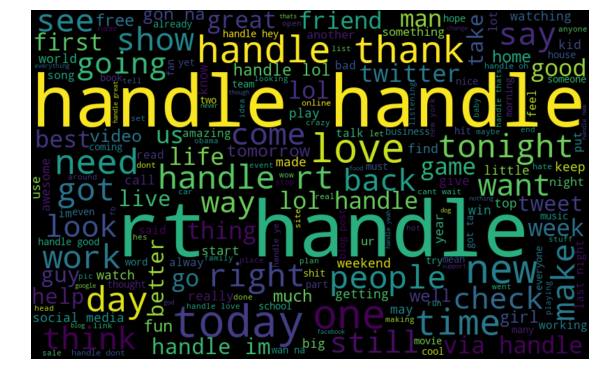

In [9]:
### create the word cloud
from wordcloud import WordCloud

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()    

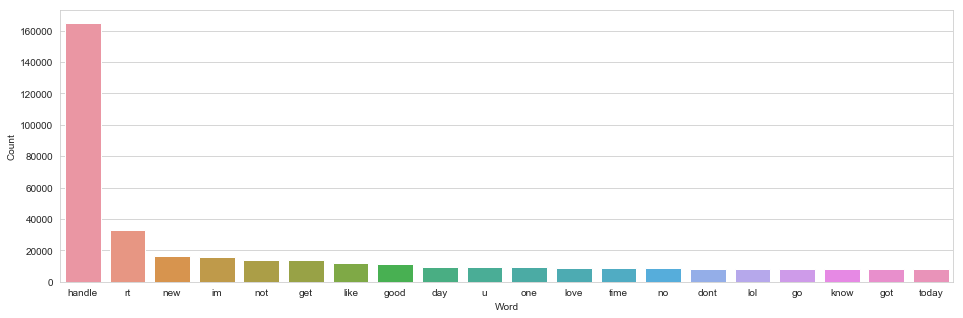

In [10]:
### count the word frequency
a = nltk.FreqDist(rmStopword)
d = pd.DataFrame({"Word": list(a.keys()),
                          "Count": list(a.values())})
# selecting top 10 most frequency      
d = d.nlargest(columns="Count", n = 20) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Word", y = "Count")
ax.set(ylabel = "Count")
plt.show()

In [11]:
### computing the number of label
numLabel = train_data['label'].unique()
print(len(numLabel))

9293


In [12]:
### TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
        
#tfidf_vectorizer = TfidfVectorizer(max_features=20, stop_words=stp)
# TF-IDF feature matrix
#tfidf = tfidf_vectorizer.fit_transform(fitTransform)
        

In [13]:
### bag-of-words feature matrix
from sklearn.feature_extraction.text import CountVectorizer
        
fitTransform = [" ".join(context) for context in train_data['words'].values]
#print("fitTransform=" + str(fitTransform))
       
bow_vectorizer = CountVectorizer(max_features=200, stop_words=stp)
#bow = bow_vectorizer.fit_transform(fitTransform) 
bow = bow_vectorizer.fit_transform(fitTransform) 
bowArray = bow.toarray()
#get_feature_names()可获取词袋中所有文本的关键字
#toarray()可看到词频矩阵的结果
print(bowArray)
#print("bow="+str(bow))
        
train_tagged = bow_vectorizer.get_feature_names()
#print (bow_vectorizer.get_feature_names())
#print("train_tagged="+str(train_tagged))

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [14]:
### Using BOW to create model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

train_bow = bow[:328195, :]
test_bow = bow[328195:, :]
#print("train_bow = " + str(train_bow))  

# splitting data into training and validation set
xtrain_bow, xvalid_bow, ytrain, yvalid = train_test_split(train_bow, train_data['label'], random_state=None, test_size=0.3)
 
#print("xtrain_bow = " + str(xtrain_bow))
#print("xvalid_bow = " + str(xvalid_bow))
#print("ytrain = " + str(ytrain))
#print("yvalid = " + str(yvalid))   

trainLabel = str(train_data['label'].unique())
#print("label="+str(train_data['label'].unique()))
      
    
lreg = LogisticRegression()
lreg.fit(xtrain_bow, ytrain) # training the model
 
prediction = lreg.predict_proba(xvalid_bow) # predicting on the validation set
#print("prediction = " + str(prediction))
#print(lreg.classes_) 
predictLabel = lreg.predict(xvalid_bow)
#print(lreg.predict(xvalid_bow))
#print("result="+lreg.predict(max(prediction)))


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [15]:
from sklearn.metrics import accuracy_score, f1_score

print('Testing accuracy %s' % accuracy_score(yvalid, predictLabel))
print('Testing F1 score: {}'.format(f1_score(yvalid, predictLabel, average='weighted')))

Testing accuracy 0.03274459419656913
Testing F1 score: 0.01785059158066693


/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
